In [670]:
import spotipy  
from spotipy.oauth2 import SpotifyOAuth  
from requests import post, get
import base64
import os
import json

CLIENT_ID = 'e156280e24a04c759d99d7d949e12d48'
CLIENT_SECRET = 'a47c6f826f1d456d8467c0ce249771ce'

def get_token():
    auth_string = CLIENT_ID + ":" + CLIENT_SECRET
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = post(url, headers = headers, data = data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

def get_auth_header(token):
    return{"Authorization": "Bearer " + token}

def search_for_artist(token, artist_name):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    # limit = 1 returns only one artist
    query = f"?q={artist_name}&type=artist&limit=1"
    query_url = url + query
    result = get(query_url, headers = headers)
    json_result = json.loads(result.content)["artists"]["items"]
    if len(json_result) == 0:
        print(f"{artist_name} does not exist")
        return None
    
    return json_result[0]


def search_for_track(token, track_id):
    url = "https://api.spotify.com/v1/tracks/{track_id}"
    headers = get_auth_header(token)
    # limit = 1 returns only one artist
    query_url = url
    result = get(query_url, headers = headers)
    json_result = json.loads(result.content)
    if len(json_result) == 0:
        print(f"{track_name} does not exist")
        return None
    
    return json_result


    
token = get_token()
result = search_for_track(token, "1FpVJ7HpZInE2GvhVE2TwT")
print(result)

# sp_oauth = SpotifyOAuth(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri='http://localhost:8888/callback', scope='user-read-private user-read-email')  
  
# access_token = sp_oauth.get_access_token()  
# refresh_token = sp_oauth.get_refresh_token()  

{'error': {'status': 400, 'message': 'invalid id'}}


In [718]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Replace 'YOUR_CLIENT_ID' and 'YOUR_CLIENT_SECRET' with your actual credentials
client_id = 'e156280e24a04c759d99d7d949e12d48'
client_secret = 'a47c6f826f1d456d8467c0ce249771ce'

def get_track_features(track_name, artist_name):
    # Set up Spotipy with client credentials
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    results = sp.search(q=f'track:{track_name} artist:{artist_name}', type='track')
    track_id = results['tracks']['items'][0]['id']

    track_features = sp.audio_features(tracks=[track_id])
    return track_features

greedy = get_track_features('greedy', 'Tate McRae')
all_too_well = get_track_features('All Too Well (10 Minute Version)', 'Taylor Swift')
print("The danceability of greedy: ", greedy[0]['danceability'])
print("The danceability of All Too Well: ", all_too_well[0]['danceability'], "\n")

print("The loudness of greedy: ", greedy[0]['loudness'])
print("The loudness of All Too Well: ", all_too_well[0]['loudness'])




# print("This is greedy features: \n", get_track_features('greedy', 'Tate McRae'))
# print("This is All Too Well features: \n", get_track_features('All Too Well (10 Minute Version)', 'Taylor Swift'))

The danceability of greedy:  0.75
The danceability of All Too Well:  0.631 

The loudness of greedy:  -3.18
The loudness of All Too Well:  -8.771


In [672]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# path to 'big-data.csv', need to have on the same directory as notebook
file_path = '2011-2020.csv'

# read the file as a pandas dataframe
df = pd.read_csv(file_path)
import re
# removing content after words "featuring," "feat.," "ft.," and "&" in columns artist and song (case-insensitive)
df['artist'] = df['artist'].str.replace(r'\s*(featuring|featuring:|feat\.|ft\.|&|\(from\))\s.*$', "", regex=True, flags=re.IGNORECASE)
df['song'] = df['song'].str.replace(r'\s*(featuring|featuring:|feat\.|ft\.|&|\(from).*$', "", regex=True, flags=re.IGNORECASE)

# merging columns with a comme-separation
merged_column = df['song'] + ', ' + df['artist']

if not "song, artist" in df.columns:
    # insert the new column into the dataframe
    df.insert(4, 'song, artist', merged_column)

# removing duplicate song, artist pairings from the dataframe
# df_no_duplicates = df.drop_duplicates(subset='song, artist', keep='first')
# for debugging
# df = df.drop('song, artist', axis = 1)

In [673]:
# df_no_duplicates.shape
# print(df_no_duplicates.tail())
# song = df['song']
# artist = df['artist']
# date = df['date']
# if 'date' in df.columns:
#     df = df.drop('date', axis = 1)
#     df = df.drop('song', axis = 1)
#     df = df.drop('artist', axis = 1)

In [674]:
# grouping dataframe by unique song, artist pairings and retaining only the rows with maximum values
weeks_on_board = df.groupby(["song, artist"]).max()

song = df['song']
artist = df['artist']
date = df['date']

if 'date' in df.columns:
    df = df.drop('date', axis = 1)
    df = df.drop('song', axis = 1)
    df = df.drop('artist', axis = 1)
    
# grouping dataframe by unique song, artist pairings and calculating the aggregate mean values
mean_rank = df.groupby(["song, artist"]).mean()
# merging the 2 previous dataframes into a single dataframe, merging on "song, artist"
merge_df_no_duplicates = pd.merge(weeks_on_board, mean_rank, on = "song, artist")

In [678]:
# dropping the unecessary columns
billboard_song_rankings = merge_df_no_duplicates.drop(columns=['peak-rank_y', 'weeks-on-board_y', 
                                                               'rank_x', 'last-week_x', 'peak-rank_x',
                                                               'last-week_y'])
billboard_song_rankings.rename(columns={'weeks-on-board_x': 'weeks_on_board', 'rank_y': 'mean_rank'}, inplace=True)

# Calculating the popularity scores
billboard_song_rankings['popularity_score'] = (1 / billboard_song_rankings["mean_rank"]) * billboard_song_rankings["weeks_on_board"]
# Filtering only the top 1000 most popular songs per decade (so as not to exceed the rate-limit in the Spotify
# API calls)
billboard_song_rankings = billboard_song_rankings.nlargest(1500, 'popularity_score')

billboard_song_rankings['song, artist'] = billboard_song_rankings['song'] + ', ' + billboard_song_rankings['artist']

In [679]:
billboard_song_rankings

,date,song,artist,weeks_on_board,mean_rank,popularity_score,"song, artist"
"song, artist",,,,,,,
"Circles, Post Malone",2020-11-07,Circles,Post Malone,61,8.786885,6.942164,"Circles, Post Malone"
"Sunflower (Spider-Man: Into The Spider-Verse), Post Malone",2019-11-02,Sunflower (Spider-Man: Into The Spider-Verse),Post Malone,53,9.301887,5.697769,"Sunflower (Spider-Man: Into The Spider-Verse),..."
"Shape Of You, Ed Sheeran",2018-03-03,Shape Of You,Ed Sheeran,59,11.310345,5.216463,"Shape Of You, Ed Sheeran"
"Blinding Lights, The Weeknd",2020-12-26,Blinding Lights,The Weeknd,55,10.963636,5.016584,"Blinding Lights, The Weeknd"
"Uptown Funk!, Mark Ronson",2016-03-05,Uptown Funk!,Mark Ronson,56,12.375000,4.525253,"Uptown Funk!, Mark Ronson"
...,...,...,...,...,...,...,...
"Heartache On The Dance Floor, Jon Pardi",2017-11-18,Heartache On The Dance Floor,Jon Pardi,18,67.944444,0.264922,"Heartache On The Dance Floor, Jon Pardi"
"Echame La Culpa, Luis Fonsi",2018-04-14,Echame La Culpa,Luis Fonsi,20,75.526316,0.264808,"Echame La Culpa, Luis Fonsi"
"Try, Colbie Caillat",2015-01-17,Try,Colbie Caillat,20,75.550000,0.264725,"Try, Colbie Caillat"


In [677]:
import pandas as pd
import numpy as np

# initiating empty dictionary
data = {}

data['date'] = np.array([])
data['song'] = np.array([])
data['artist'] = np.array([])
data['danceability'] = np.array([])
data['energy'] = np.array([])
data['key'] = np.array([])
data['loudness'] = np.array([])
data['mode'] = np.array([])
data['speechiness'] = np.array([])
data['acousticness'] = np.array([])
data['instrumentalness'] = np.array([])
data['liveness'] = np.array([])
data['valence'] = np.array([])
data['tempo'] = np.array([])
data['duration_ms'] = np.array([])


# Finding song features and appending them to the dictionary. Key: Feature. Value: Value of Features 
for index, row in tqdm(billboard_song_rankings.iterrows()):
    try:
        song_features = get_track_features(row['song'], row['artist'])
        # Appending danceability feature 
        data['danceability'] = np.append(data['danceability'], song_features[0]['danceability'])
        
        data['song'] = np.append(data['song'], row['song'])
        data['artist'] = np.append(data['artist'], row['artist'])
        data['date'] = np.append(data['date'], row['date'])
        # Appending energy feature 
        data['energy'] = np.append(data['energy'], song_features[0]['energy'])

        # Appending key feature 
        data['key'] = np.append(data['key'], song_features[0]['key'])

        # Appending loudness feature 
        data['loudness'] = np.append(data['loudness'], song_features[0]['loudness'])

        # Appending mode feature 
        data['mode'] = np.append(data['mode'], song_features[0]['mode'])

        # Appending speechiness feature 
        data['speechiness'] = np.append(data['speechiness'], song_features[0]['speechiness'])

        # Appending acousticness feature 
        data['acousticness'] = np.append(data['acousticness'], song_features[0]['acousticness'])

        # Appending instrumentalness feature 
        data['instrumentalness'] = np.append(data['instrumentalness'], song_features[0]['instrumentalness'])

        # Appending liveness feature
        data['liveness'] = np.append(data['liveness'], song_features[0]['liveness'])

        # Appending valence feature 
        data['valence'] = np.append(data['valence'], song_features[0]['valence'])

        # Appending tempo feature 
        data['tempo'] = np.append(data['tempo'], song_features[0]['tempo'])

        # Appending duration_ms feature 
        data['duration_ms'] = np.append(data['duration_ms'], song_features[0]['duration_ms'])
        
    except IndexError as e:
        print(f"Error at index {row['song']}: {e}")
        continue  # Skip to the next iteration when an error occurs
    
    except MaxRetryError as mre:
        features_df = pd.DataFrame(data)
        continue
    
features_df = pd.DataFrame(data)

print(features_df)


35it [00:31,  1.12s/it]

Error at index Can't Stop The Feeling!: list index out of range


47it [00:38,  2.19it/s]

Error at index F**k You! (Forget You): list index out of range


54it [00:45,  1.07it/s]

Error at index Can't Feel My Face: list index out of range


81it [01:04,  1.25it/s]


NameError: name 'MaxRetryError' is not defined

In [ ]:
dataset_features_df = features_df
dataset_features_df['song, artist'] = dataset_features_df['song'] + ', ' + dataset_features_df['artist']
dataset_features_df = pd.merge(dataset_features_df, billboard_song_rankings['popularity_score'], on = "song, artist")
dataset_features_df

In [ ]:
# dataset_features_df.to_csv('1991-2000_scraped.csv', index=False)

In [ ]:
# import pandas as pd
# import numpy as np

# # Trial dataframe
# data = {'Song': ['DNA', 'All I Want for Christmas Is You', 'All I Want for Christmas Is You'],
#         'Artist': ["Kendrick Lamar", "Mariah Carey", "Michael Buble"],
#         'Song, Artist': ['DNA, Kendrick Lamar', 'All I Want for Christmas Is You, Mariah Carey', 'All I Want for Christmas Is You, Michael Buble']}
# df = pd.DataFrame(data)

# data['song'] = np.array([])
# data['artist']
# data['danceability'] = np.array([])
# data['energy'] = np.array([])
# data['key'] = np.array([])
# data['loudness'] = np.array([])
# data['mode'] = np.array([])
# data['speechiness'] = np.array([])
# data['acousticness'] = np.array([])
# data['instrumentalness'] = np.array([])
# data['liveness'] = np.array([])
# data['valence'] = np.array([])
# data['tempo'] = np.array([])
# data['duration_ms'] = np.array([])


# # Replace dataframe variable with dataframe of choice
# for song_artist_pair in df['Song, Artist']:
#     result_list = [item.strip() for item in song_artist_pair.split(',')]
#     song_name, artist_name = result_list[0], result_list[1]
#     song_features = get_track_features(song_name, artist_name)
#     # Appending danceability feature 
#     data['danceability'] = np.append(data['danceability'], song_features[0]['danceability'])
    
#     # Appending energy feature 
#     data['energy'] = np.append(data['energy'], song_features[0]['energy'])
    
#     # Appending key feature 
#     data['key'] = np.append(data['key'], song_features[0]['key'])
    
#     # Appending loudness feature 
#     data['loudness'] = np.append(data['loudness'], song_features[0]['loudness'])
    
#     # Appending mode feature 
#     data['mode'] = np.append(data['mode'], song_features[0]['mode'])
    
#     # Appending speechiness feature 
#     data['speechiness'] = np.append(data['speechiness'], song_features[0]['speechiness'])
    
#     # Appending acousticness feature 
#     data['acousticness'] = np.append(data['acousticness'], song_features[0]['acousticness'])
    
#     # Appending instrumentalness feature 
#     data['instrumentalness'] = np.append(data['instrumentalness'], song_features[0]['instrumentalness'])
    
#     # Appending liveness feature
#     data['liveness'] = np.append(data['liveness'], song_features[0]['liveness'])
    
#     # Appending valence feature 
#     data['valence'] = np.append(data['valence'], song_features[0]['valence'])
    
#     # Appending tempo feature 
#     data['tempo'] = np.append(data['tempo'], song_features[0]['tempo'])
    
#     # Appending duration_ms feature 
#     data['duration_ms'] = np.append(data['duration_ms'], song_features[0]['duration_ms'])
    
# features_df = pd.DataFrame(data)

# print(features_df)


In [691]:
df_11_20 = pd.read_csv('2011-2020_scraped.csv')
# df_11_20.insert(15, 'popularity_score', popularity_score)

if not 'song, artist' in df_11_20.columns:
    df_11_20['song, artist'] = df_11_20['song'] + ', ' + df_11_20['artist']
    df_11_20 = pd.merge(df_11_20, billboard_song_rankings['popularity_score'], on = "song, artist")
    df_11_20.to_csv('2011-2020_scraped.csv', index = False)

In [694]:
# Replace 'your_file_path.csv' with the path to your CSV file
df_71_80 = pd.read_csv('1971-1980_scraped.csv')
df_81_90 = pd.read_csv('1981-1990_scraped.csv')
df_91_00 = pd.read_csv('1991-2000_scraped.csv')
df_01_10 = pd.read_csv('2001-2010_scraped.csv')
df_11_20 = pd.read_csv('2011-2020_scraped.csv')

# Replace 'df1', 'df2', 'df3', ... with your actual DataFrame names
list_of_dfs = [df_11_20, df_01_10, df_91_00, df_81_90, df_71_80]

# Concatenate the DataFrames along rows (axis=0)
big_df = pd.concat(list_of_dfs, axis=0, ignore_index=True)
# Now 'df' is your DataFrame containing the data from the CSV file

In [695]:
big_df.to_csv('scraped-data.csv', index = False)

In [697]:
!pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/f6/5e/eb46f7b7e64318377adf7dec0e38e22c022b256eb51985fd14e4b9eb5084/shap-0.44.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.9/450.9 kB 630.1 kB/s eta 0:00:00a 0:00:01


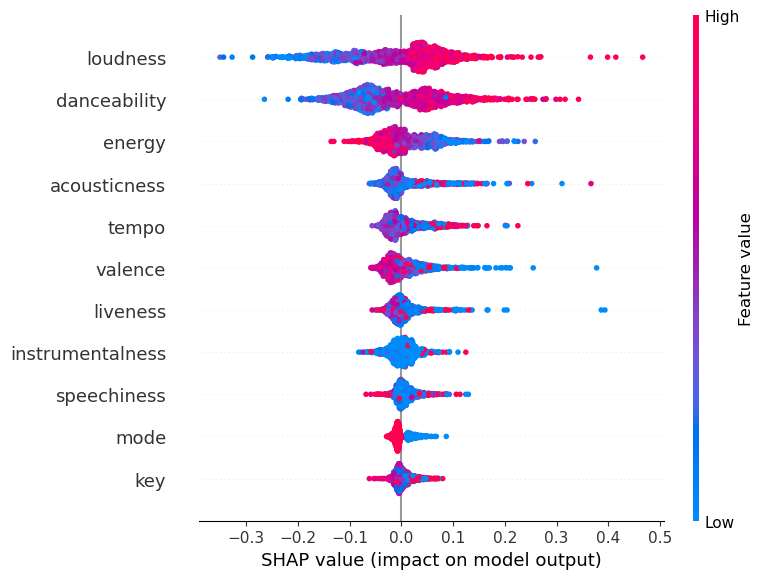

In [706]:
## Using SHAP to find feature importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

# Dropping the duration_ms feature because it does not impact popularity of song
shap_df = big_df
shap_df = shap_df.drop(columns = ["duration_ms"])

# Coming up with feature matrix and target array
feature_matrix = shap_df.iloc[:, 4:15]
target_array = shap_df.iloc[:, 15]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target_array, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, show = False, feature_order = feature_order)

plt.savefig('shap_summary_plot_10s.png')